# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Detect environment

In [2]:
from pkg.marker_config import *
from pkg.environment_builder import *
from pkg.geometry import *
from pkg.utils import *

init_stereo()
aruco_map, dictionary = get_aruco_config()

ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)

xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE,
        env_dict={'floor': CallHolder(GeoBox, ["center", "orientation"], BLH=(1.52,0.72,0.01)), 
                  'wall':CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01))},  
        camT_dict={"cam0":np.identity(4), "cam1": T_c12}, 
        ref_name='floor')

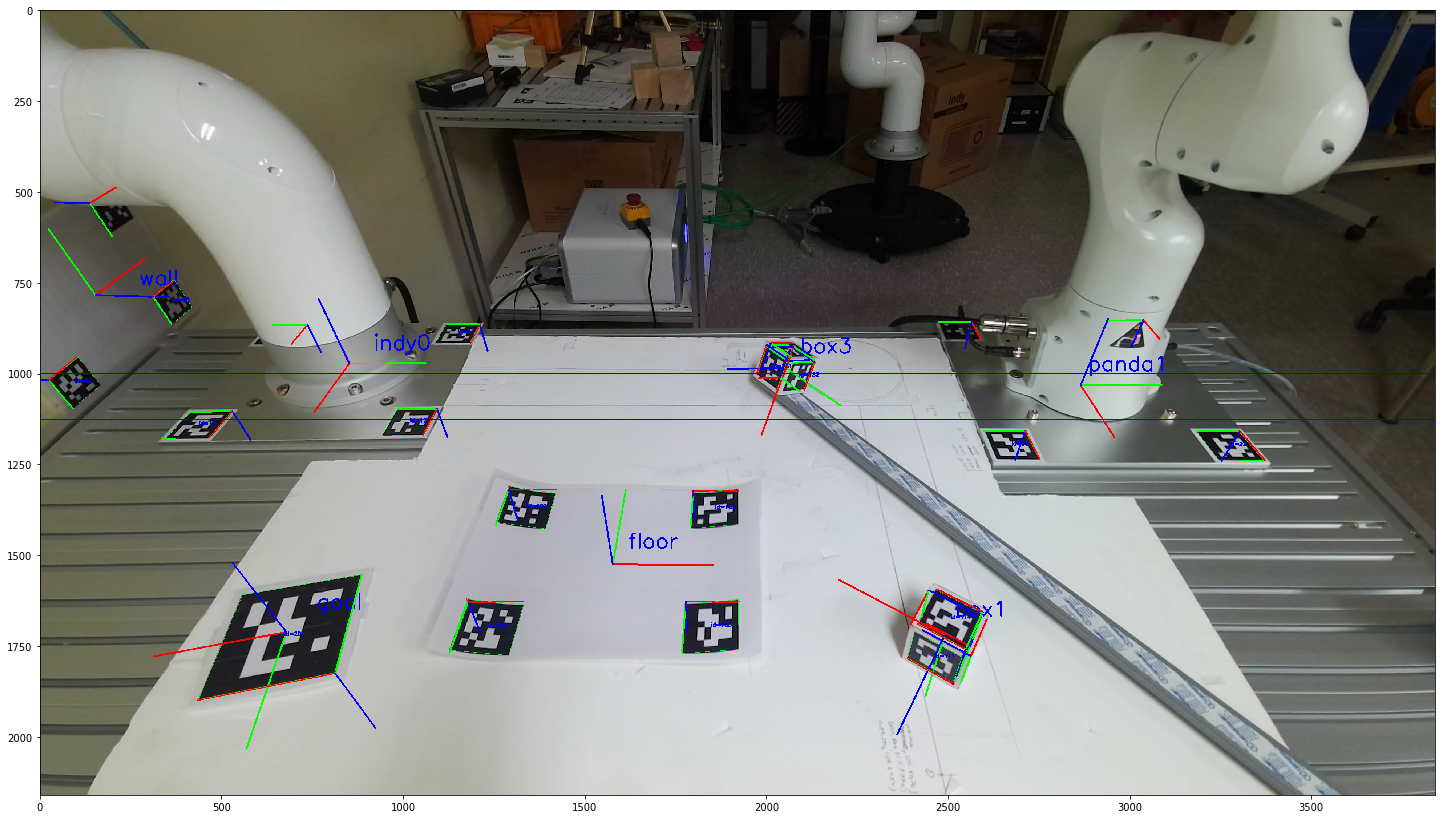

In [4]:
plt.figure(figsize=(25,15))
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

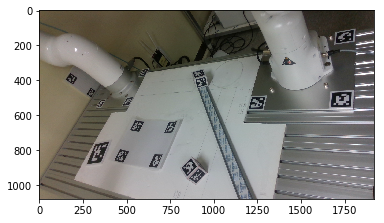

In [5]:
plt.imshow(get_rs_image()[:,:,[2,1,0]])

In [6]:
# with open('config.pkl', 'wb') as f:
#     pickle.dump({"objectPose_dict":objectPose_dict, "corner_dict":corner_dict}, f)

In [7]:
# disconnRobotType.indy7_robotect_stereo()

# Define robot config

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer(ROBOTS_ON_SCENE, xyz_rpy_robots)

vel_scale, acc_scale = 0.5, 0.5
custom_limits = {}
XacroCustomizer.update_limit_dict(custom_limits, "vel", JOINT_NAMES_DEFINED, 
                                  vel_scale * np.deg2rad(
        [150, 150, 150, 180, 180, 180, 150, 150, 150, 150, 180, 180, 180]))
XacroCustomizer.update_limit_dict(custom_limits, "acc", JOINT_NAMES_DEFINED, 
                                  acc_scale * np.deg2rad(
        [360]*len(JOINT_NAMES_DEFINED)))
custom_limits['panda1_joint1']['lower'], custom_limits['panda1_joint1']['upper'] = -2.75, 2.75
custom_limits['panda1_joint2']['lower'], custom_limits['panda1_joint2']['upper'] = -1.70, 1.70
custom_limits['panda1_joint3']['lower'], custom_limits['panda1_joint3']['upper'] = -2.75, 2.75
custom_limits['panda1_joint4']['lower'], custom_limits['panda1_joint4']['upper'] = -2.9, -0.1
custom_limits['panda1_joint5']['lower'], custom_limits['panda1_joint5']['upper'] = -2.75, 2.75
custom_limits['panda1_joint6']['lower'], custom_limits['panda1_joint6']['upper'] = 0.1, 3.6
custom_limits['panda1_joint7']['lower'], custom_limits['panda1_joint7']['upper'] = -2.75, 2.75


JOINT_NAMES, LINK_NAMES, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={},
        joint_limit_dict=custom_limits)
refine_meshes()
xcustom.start_rviz()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


# Create Graph

In [9]:
from pkg.constraint_graph import *
from pkg.constants import *
from pkg.plot_utils import *
from pkg.utils import *

rospy.init_node('task_planner', anonymous=True)

In [10]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = False, connect_indy = False)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

add_cam_poles(graph, xyz_rvec_cams)
add_objects_gen(graph, env_gen_dict)

if graph.connect_indy:
    graph.indy.connect_and(graph.indy.joint_move_to,np.rad2deg(ZERO_JOINT_POSE[graph.indy_idx]))
if graph.connect_panda:
    graph.panda.move_joint_interpolated(ZERO_JOINT_POSE[graph.panda_idx], N_div=300)
    graph.panda.set_k_gain(70)
    graph.panda.set_d_gain(7)

## add custom meshes

In [11]:
graph.add_geometry_items([
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm2_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox((0, 0,0.0675), (0.05,0.05,0.130), orientation=(0,0,0), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.3), collision=True),
                           GeoSegment((-0.1,0,0.03), (0,np.pi/2,0), 0.2, 0.05, name="indy0_plug", link_name="indy0_link0",
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True),
                           GeoSegment((-0.05,0,0.03), (np.pi/2,0.0,0.0), 0.3, 0.05, name="cableset", link_name="panda1_link0", 
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True)
    ], fixed=True)

## Register binders

In [12]:
graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,112e-3], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=(0, 0,0.132), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# Add objects

In [13]:
MOVABLE_GENERATORS = {'box1': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.3,0.3,1)), 
                 'box2': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.3,0.3,0.8,1)), 
                 'box3': CallHolder(GeoSphere, ["center", None], radius=0.15, color=(0.8,0.8,0.0,0.3), collision=False), 
                 'goal': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.1, 0.1,0.01), color=(0.8,0.0,0.0,1))}
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.008], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

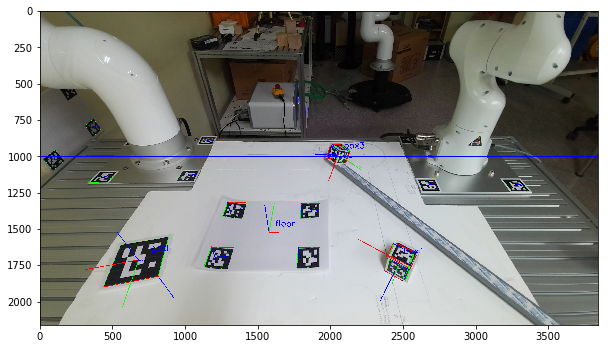

In [14]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
put_point_dict = register_objects(graph, objectPose_dict_mv, MOVABLE_GENERATORS, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=("floor", objectPose_dict["floor"]), link_name="world")

plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Set RVIZ

In [15]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)
    

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# srdf

In [16]:
robot_names = [tup[0] for tup in ROBOTS_ON_SCENE]
binder_links = [blink.object.link_name for blink in graph.binder_dict.values()]
link_names = graph.link_names
joint_names = graph.joint_names
urdf_content = graph.urdf_content
urdf_path = graph.urdf_path

In [17]:
srdf_path = write_srdf(robot_names, binder_links, link_names, joint_names, urdf_content, urdf_path)

In [18]:
import tesseract
import os
import re
import numpy as np
rospack = rospkg.RosPack()

class TesseractSupportResourceLocator(tesseract.ResourceLocator):
    def __init__(self):
        super(TesseractSupportResourceLocator,self).__init__()

    def locateResource(self, url):
        pkg_name = url.split('/')[2]
        fname = os.path.join(rospack.get_path(pkg_name), url[url.index(pkg_name)+len(pkg_name)+1:])
        with open(fname,'rb') as f:
            resource_bytes = f.read()

        resource = tesseract.BytesResource(url, resource_bytes)

        return resource

def _load_tesseract(urdf_path, srdf_path):

    with open(urdf_path,'r') as f:
        robot_urdf = f.read()

    with open(srdf_path,'r') as f:
        robot_srdf = f.read()

    t = tesseract.Tesseract()

    t.init(robot_urdf, robot_srdf, TesseractSupportResourceLocator())
    return t

In [19]:
rname = robot_names[1]
blink = [lname for lname in link_names if rname in lname and urdf_content.joint_map[get_parent_joint(lname)].parent == "world"][0]
elink = [elink for elink in binder_links if rname in elink][0]
dim_manip = len([jname for jname in joint_names if rname in jname])

In [20]:
for joint in urdf_content.joints:
    if joint.limit is not None:
        print("{}: {}/{}".format(joint.name, joint.limit.upper, joint.limit.lower))

indy0_joint0: 3.05432619099/-3.05432619099
indy0_joint1: 3.05432619099/-3.05432619099
indy0_joint2: 3.05432619099/-3.05432619099
indy0_joint3: 3.05432619099/-3.05432619099
indy0_joint4: 3.05432619099/-3.05432619099
indy0_joint5: 3.75245789179/-3.75245789179
panda1_joint1: 2.75/-2.75
panda1_joint2: 1.7/-1.7
panda1_joint3: 2.75/-2.75
panda1_joint4: -0.1/-2.9
panda1_joint5: 2.75/-2.75
panda1_joint6: 3.6/0.1
panda1_joint7: 2.75/-2.75


In [21]:
(np.array([0,-np.pi*1/3,-np.pi*2/3,-np.pi/2,-np.pi*2/3, np.pi/2, 0])).tolist()

[0.0,
 -1.0471975511965976,
 -2.0943951023931953,
 -1.5707963267948966,
 -2.0943951023931953,
 1.5707963267948966,
 0.0]

In [22]:
from scipy.spatial import ConvexHull

In [31]:
points = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            points.append((i,j,k))
points = np.array(points)

In [38]:
points1 = points.copy()
points2 = points + 1

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

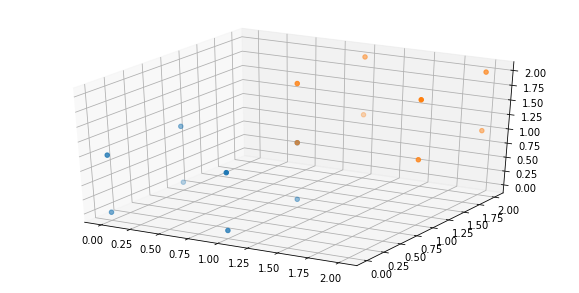

In [41]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object
ax.scatter(points1[:,0], points1[:,1], points1[:,2])
ax.scatter(points2[:,0], points2[:,1], points2[:,2])

In [43]:
points_cat = np.concatenate([points1, points2], axis=0)

In [26]:
np.array(points).shape

(8, 3)

In [61]:
gtimer.reset()

In [63]:
len(graph.fixed_collision_items_list)

24

In [64]:
len(graph.movable_collision_items_list)

2

In [66]:
import pybullet

In [70]:
pybullet.connect(pybullet.DIRECT)

0

In [71]:
pybullet.createCollisionShape(pybullet.GEOM_MESH)

error: createCollisionShape failed.

In [62]:
gtimer.tic('hull')
hull = ConvexHull(points_cat)
cpoints = hull.points[hull.vertices]
gtimer.toc('hull')

0.4909038543701172

In [54]:
hull.vertices

14

In [47]:
len(hull.points)

16

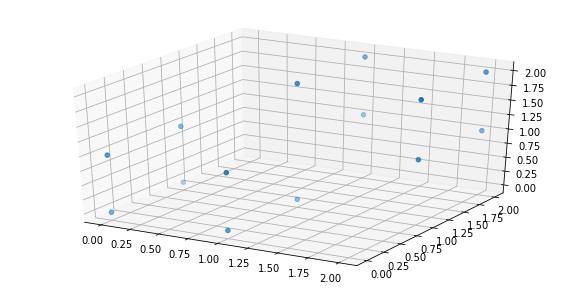

In [56]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d') # Axe3D object
ax.scatter(cpoints[:,0], cpoints[:,1], cpoints[:,2])

In [ ]:
t = _load_tesseract(urdf_path, srdf_path)

dim_manip = len([jname for jname in joint_names if rname in jname])

# q_s = np.random.rand(dim_manip)*np.deg2rad(90)
# q_e = np.random.rand(dim_manip)*np.deg2rad(90)

q_s = np.array([0,np.pi*1/3,np.pi*1/3,-np.pi/2,-np.pi*1/3, np.pi/2, 0])
q_e = np.array([0,-np.pi*1/3,-np.pi*2/3,-np.pi/2,-np.pi*2/3, np.pi/2, 0])
# q_e = q_s+np.random.rand(dim_manip)*np.deg2rad(60)

# q_s = np.array([0]+[np.pi*1/3]*5)
# q_e = np.array([0]+[-np.pi*1/3]*5)
 
pci = tesseract.ProblemConstructionInfo(t)

pci.init_info.type = tesseract.InitInfo.STATIONARY
#pci.init_info.data = np.array([0.0,0,0,0,0,0])

pci.basic_info.n_steps = 2
pci.basic_info.manip = rname
pci.basic_info.start_fixed = False
pci.basic_info.use_time = False

pci.opt_info.max_iter = 10000
pci.opt_info.min_approx_improve = 1e-3
pci.opt_info.min_trust_box_size = 1e-3

pci.kin = pci.getManipulator(pci.basic_info.manip)

start_pos_terminfo = tesseract.JointPosTermInfo()
start_pos_terminfo.name="start"
start_pos_terminfo.term_type = tesseract.TT_CNT
#start_pos_terminfo.coeffs=np.ones(6)
start_pos_terminfo.first_step = 0
start_pos_terminfo.last_step = 0

start_pos_terminfo.targets=q_s # np.random.rand(7)*0.0

end_pos_terminfo = tesseract.JointPosTermInfo()
end_pos_terminfo.name = "end"
end_pos_terminfo.term_type = tesseract.TT_CNT
#end_pos_terminfo.coeffs=np.ones(6)
end_pos_terminfo.targets=q_e # np.random.rand(7)*0.1
end_pos_terminfo.first_step = pci.basic_info.n_steps-1
end_pos_terminfo.last_step = pci.basic_info.n_steps-1

joint_vel = tesseract.JointVelTermInfo()
joint_vel.coeffs = np.ones(dim_manip)
joint_vel.targets = np.zeros(dim_manip)
joint_vel.first_step = 0
joint_vel.last_step = pci.basic_info.n_steps - 1
joint_vel.name = "Joint_vel"
joint_vel.term_type = tesseract.TT_COST

time_terminfo = tesseract.TotalTimeTermInfo()
time_terminfo.coeff = 1
time_terminfo.term_type = tesseract.TT_COST | tesseract.TT_USE_TIME
time_terminfo.name = "time"

collision = tesseract.CollisionTermInfo()
collision.name = "collision"
collision.term_type = tesseract.TT_CNT
collision.continuous = True
collision.first_step = 0
collision.last_step = pci.basic_info.n_steps-1
collision.gap = 1
collision_info = tesseract.createSafetyMarginDataVector(pci.basic_info.n_steps, .0001, 40)
for i in collision_info:
    collision.info.append(i)

pci.cnt_infos.append(start_pos_terminfo)
pci.cnt_infos.append(end_pos_terminfo)
# pci.cost_infos.append(time_terminfo)
pci.cnt_infos.push_back(collision)
pci.cost_infos.push_back(joint_vel)

prob = tesseract.ConstructProblem(pci)
config = tesseract.TrajOptPlannerConfig(prob)

planner = tesseract.TrajOptMotionPlanner()

tvec=[]
planner.setConfiguration(config)
t1 = time.time()
planner_status_code, planner_response = planner.solve()
t2 = time.time()
tvec.append(t2-t1)

assert planner_status_code.value() == 0, "Planning failed"

print(planner_response.joint_trajectory.trajectory)

print(tvec)

#TODO: test more stuff...

In [72]:
Q_list = []
for Q_rbt in planner_response.joint_trajectory.trajectory:
    Q = np.zeros(graph.joint_num)
    Q[[i_j for i_j, jname in zip(range(graph.joint_num), graph.joint_names) if rname in jname]] = Q_rbt
    Q_list.append(Q)
Q_list = np.array(Q_list)
graph.show_motion(Q_list, period=1, error_skip=0)

In [55]:
# graph.show_pose(q_s.tolist()+[0,0,0,0,0,0,0])
graph.show_pose([0,0,0,0,0,0]+q_s.tolist())

In [56]:
# graph.show_pose(q_e.tolist()+[0,0,0,0,0,0,0])
graph.show_pose([0,0,0,0,0,0]+q_e.tolist())

In [62]:

graph.show_pose([0,0,0,0,0,0]+(np.array([0,np.pi*1/3,np.pi*1/3,-np.pi/2,-np.pi*1/3, np.pi/2, 0])).tolist())

In [66]:
graph.show_pose([0,0,0,0,0,0]+(np.array([0,-np.pi*1/3,-np.pi*2/3,-np.pi/2,-np.pi*2/3, np.pi/2, 0])).tolist())

In [203]:
N_test = 4

t = _load_tesseract(urdf_path, srdf_path)

config = tesseract.TrajOptPlannerDefaultConfig(t,rname, elink, np.eye(4))

config.params.cnt_tolerance = 1e-5

for ind in range(N_test):
    tcp_pose = np.array([[0,0,1,0],[0,1,0,0],[-1,0,0, 0],[0,0,0,1]],dtype=np.float64)
    tcp_pose[0,3] = 0.5
    tcp_pose[1,3] = -0.2 + ind*.4/(N_test-1)
    tcp_pose[2,3] = 0.4

    waypoint = tesseract.CartesianWaypoint(tcp_pose, blink)

    config.target_waypoints.push_back(waypoint)

config.target_waypoints[0].setIsCritical(True)
config.target_waypoints[N_test-1].setIsCritical(True)

planner = tesseract.TrajOptMotionPlanner()


tvec = []
for _ in range(1):
    planner.setConfiguration(config)
    t1 = time.time()
    planner_status_code, planner_response = planner.solve(True)
    t2 = time.time()
    tvec.append(t2-t1)

assert planner_status_code.value() == 0, "Planning failed"

print(planner_response.joint_trajectory.trajectory)
print(tvec)

[[-0.04969329 -0.33766961 -2.44351356 -0.05309895  1.21085201  0.01871803]
 [ 0.39840644 -0.22820821 -2.33329248  0.46623625  1.04121298 -0.24894987]
 [ 0.68417691 -0.20166138 -2.11107034  0.87891952  0.9627609  -0.60365065]
 [ 0.87338562 -0.28597288 -1.86669351  1.13925853  1.00445693 -0.86154025]]
[0.5323960781097412]


In [205]:
Q_list = []
for Q_rbt in planner_response.joint_trajectory.trajectory:
    Q = np.zeros(graph.joint_num)
    Q[[i_j for i_j, jname in zip(range(graph.joint_num), graph.joint_names) if rname in jname]] = Q_rbt
    Q_list.append(Q)
graph.show_motion(Q_list, period=1)

# Search Graph (Custom Robots)

In [20]:
graph.build_graph()

In [21]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
graph.show_pose(ZERO_JOINT_POSE)

In [22]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")

graph.search_graph(
    initial_state = initial_state, goal_nodes = goal_nodes,
    tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
print(gtimer)


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.55 s, err: 0.00399015705499)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.15 s, err: 0.189602617041)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.7 s, err: 0.116108598379)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.25 s, err: 0.47803828299)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.81 s, err: 0.182537964232)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (3.07 s, err: 0.000951769949866)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> 

search_graph: 	7887.0 ms/1 = 7886.942 ms (7886.942/7886.942)
init_search: 	3.0 ms/1 = 3.114 ms (3.114/3.114)
score_graph: 	2.0 ms/8 = 0.198 ms (0.149/0.265)
reset_valid_node: 	1.0 ms/201 = 0.005 ms (0.001/0.1)
check_goal: 	0.0 ms/208 = 0.001 ms (0.0/0.014)
get_valid_neighbor: 	0.0 ms/18 = 0.008 ms (0.005/0.011)
add_node_queue_leafs: 	2.0 ms/4 = 0.613 ms (0.183/1.078)
__search_loop: 	7881.0 ms/1 = 7880.686 ms (7880.686/7880.686)
simulate_transition: 	7819.0 ms/14 = 558.487 ms (237.173/787.865)
start set transition: 	38.0 ms/14 = 2.715 ms (1.832/5.821)
get_transition_context: 	38.0 ms/14 = 2.709 ms (1.829/5.81)
set_object_state: 	14.0 ms/28 = 0.483 ms (0.191/2.083)
start get_tf_text: 	7.0 ms/14 = 0.528 ms (0.402/0.876)
start get_collision_text: 	19.0 ms/14 = 1.333 ms (0.947/2.646)
start make_constraints: 	1.0 ms/14 = 0.07 ms (0.036/0.231)
set_simulate fun: 	7773.0 ms/14 = 555.218 ms (232.931/785.115)
post: 	8.0 ms/14 = 0.536 ms (0.227/1.796)
get_object_state: 	0.0 ms/14 = 0.021 ms (0.014

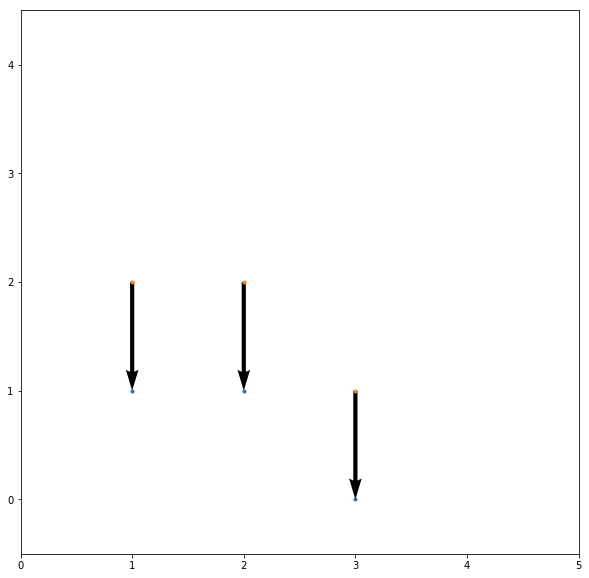

In [23]:
graph.quiver_snodes()
print(gtimer)

# Replay schedule

In [24]:
N_fullstep = 500
dt_vis = 0.01
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:1], range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 2, 3]

--------------------
2-(('box1', 'front_p', 'vac2'),)

--------------------
3-(('box1', 'back_p', 'goal_bd'),)


In [58]:
gtimer.reset()
e, end_state, success = graph.simulate_transition(
    graph.snode_dict[schedule[0]].state, graph.snode_dict[schedule[1]].state, 
    N=1000, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, collision=False)
print(success)

True


In [65]:
gtimer.reset()
self = graph
from_state, to_state = graph.snode_dict[schedule[0]].state, graph.snode_dict[schedule[1]].state
N=1000
dt=dt_sim
vel_conv=1e-2
err_conv=1e-3
collision=False

display=False
dt_vis=None
error_skip=1e-4
N_step=10
print_expression=False
kwargs = {}

In [71]:
if dt_vis is None:
    dt_vis = dt/10
self.gtimer = GlobalTimer.instance()
self.gtimer.tic("start set transition")
full_context, pos_start, kwargs, binding_list = self.get_transition_context(
    from_state, to_state, vel_conv, err_conv, collision=collision, **kwargs)
self.gtimer.toc("start set transition")
if print_expression:
    print(full_context)
    
self.gtimer.tic("get_simulation")
success = False
e = get_simulation(full_context)
self.gtimer.toc("get_simulation")
self.gtimer.tic("do_simulate")
e = do_simulate(e, initial_jpos=np.array(pos_start), N=N, dt=dt, **kwargs)
if hasattr(e, 'POS'):
    pos_start = e.POS[-1]

if hasattr(e, 'error') and e.error<err_conv:
    success = True
self.gtimer.toc("do_simulate")

self.gtimer.tic("post")
if from_state is not None:
    self.set_object_state(from_state)
if success:
    for bd in binding_list:
        self.rebind(bd, e.joint_dict_last)

node, obj_pos_dict = self.get_object_state()
end_state = State(node, obj_pos_dict, list(e.POS[-1]) if hasattr(e, 'POS') else None)
self.gtimer.toc("post")
# print(self.gtimer)
# return e, end_state, success

1.4569759368896484

In [72]:
print(gtimer)

start set transition: 	4.0 ms/3 = 1.327 ms (0.998/1.739)
get_transition_context: 	4.0 ms/3 = 1.228 ms (0.908/1.632)
set_object_state: 	2.0 ms/5 = 0.427 ms (0.211/0.76)
start get_tf_text: 	2.0 ms/3 = 0.574 ms (0.466/0.777)
start get_collision_text: 	0.0 ms/3 = 0.001 ms (0.0/0.001)
start make_constraints: 	0.0 ms/3 = 0.045 ms (0.043/0.047)
post: 	3.0 ms/2 = 1.428 ms (1.4/1.457)
rebind: 	2.0 ms/2 = 0.773 ms (0.753/0.793)
get_object_state: 	0.0 ms/2 = 0.026 ms (0.025/0.027)
get_simulation: 	73.0 ms/2 = 36.723 ms (36.135/37.312)
do_simulate: 	36.0 ms/1 = 36.476 ms (36.476/36.476)



In [79]:
graph.show_motion(e.POS, error_skip=0)

In [59]:
print(gtimer)

simulate_transition: 	67.0 ms/1 = 67.29 ms (67.29/67.29)
start set transition: 	1.0 ms/1 = 1.476 ms (1.476/1.476)
get_transition_context: 	1.0 ms/1 = 1.47 ms (1.47/1.47)
set_object_state: 	1.0 ms/2 = 0.445 ms (0.185/0.704)
start get_tf_text: 	1.0 ms/1 = 0.648 ms (0.648/0.648)
start get_collision_text: 	0.0 ms/1 = 0.001 ms (0.001/0.001)
start make_constraints: 	0.0 ms/1 = 0.046 ms (0.046/0.046)
set_simulate fun: 	65.0 ms/1 = 64.77 ms (64.77/64.77)
post: 	1.0 ms/1 = 1.02 ms (1.02/1.02)
post rebind: 	1.0 ms/1 = 0.779 ms (0.779/0.779)
rebind: 	1.0 ms/1 = 0.769 ms (0.769/0.769)
get_object_state: 	0.0 ms/1 = 0.022 ms (0.022/0.022)



# Execute traj online

In [24]:
schedule = schedule_sorted[0]
state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
obs_names = ["box3"]

with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
        RvizPublisher(graph, obs_names) as rviz_pub:
    graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                  obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


KeyboardInterrupt: 

# onestep

In [39]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))

        goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes,
            tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.44 s, err: 0.685238307896)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.98 s, err: 0.000952943417618)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.1 s, err: 0.130097449087)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.28 s, err: 0.0730680494845)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.43 s, err: 0.0751908029837)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.86 s, err: 0.0931139914436)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.92 s, err: 0.22433769414)======================================================================================================================================================

node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (1.97 s, err: 0.0311672527169)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.43 s, err: 0.523912952039)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 2->4 (2.49 s, err: 0.000878074632719)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching:


fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.77 s, err: 1.07132624998)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.83 s, err: 0.178718802768)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.9 s, err: 0.359958114867)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.03 s, err: 0.0953188927428)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.16 s, err: 1.17258966935)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.34 s, err: 0.00171795120759)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> 


fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.21 s, err: 0.691332443556)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.26 s, err: 0.471464976741)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.29 s, err: 0.909561308472)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.32 s, err: 0.262940680292)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'right_p', 'grip1'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.36 s, err: 1.43676829991)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (6.38 s, err: 0.132767984117)======================================================================================================================================================
node: (('box1', 'bottom_p', 'grip1'),)-

In [40]:
loop_process.stop_now=True

In [41]:
t_loop.is_alive()

True

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [38]:
self.reset_panda()